## Is our inference unbiased?

In this notebook, we investigate whether our inference pipelines display a bias. To do that, we run the pipelines $N$ times, drawing uniformly a fiducial value of $H_0 \in [20, 140] \, \rm{km} \, \rm{s}^{-1} \, \rm{Mpc}^{-1}$.

In [60]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from catalog.utils import GalaxyCatalog
from utils.io import write_to_hdf5
from inference.pp_analysis import (
    plot_cumulative,
    plot_sigma, 
    pp_analysis_specz,
    pp_analysis_photoz
)

In [61]:
# Notebook settings
verbose = True
save_figures = True
figures_prefix = 'figures/pp_analysis/'

In [62]:
n_H0 = 200
n_sim = 100
H0_array = np.linspace(20., 140., n_H0)
c_values = [0.1, 0.2, 0.3]

# Galaxy and GW parameters
n_gw = 50
n_z = 2000
z_max = 1.4
n_dir = 5
n_min = 100
n_gw_per_dir = round(n_gw / n_dir)
alpha = np.radians(2)

filename = "./catalog/output.hdf5"
catalog = GalaxyCatalog(filename)

In [63]:
# Draw galaxy redshifts and masses in n_dir directions, with at least n_min per direction
drawn_galaxies = catalog.draw_galaxies(n_dir, alpha, n_min)
z_gal = [catalog.z[galaxies_at_direction] for galaxies_at_direction in drawn_galaxies]
mass_gal = [catalog.mass[galaxies_at_direction] for galaxies_at_direction in drawn_galaxies]
z_min = min([np.min(z_gal_i) for z_gal_i in z_gal])
z = np.linspace(z_min, z_max, n_z)
ci_arr = np.linspace(0., 0.99, 1000)

output_data_filename = "data/pp_analysis.hdf5"

attrs = {
    'n_gw': n_gw,
    'n_sim': n_sim
}
write_to_hdf5(output_data_filename, attrs=attrs)

For each drawn value of fiducial $H_0$, we collect the minimal symmetric credible interval (CI) within which it lies. We then plot a cumulative histogram: for each percentile $\alpha$, the corresponding fraction of the $N$ inference runs for which the true $H_0$ lied within the $\alpha$-CI.

In [64]:
specz_inference_results = {'weighted':{}, 'not_weighted':{}}
for c in c_values:
    data, counts, bins = pp_analysis_specz(n_sim, H0_array, c, z_gal, n_gw_per_dir, event_weights=mass_gal, desc=f"specz-not_weighted_c_{c}")
    write_to_hdf5(output_data_filename, prefix='specz/not_weighted/', data={f'c={c}': data})
    specz_inference_results['not_weighted'].update(**{f'c = {c}':(counts, bins)})
    
    data, counts, bins = pp_analysis_specz(n_sim, H0_array, c, z_gal, n_gw_per_dir, event_weights=mass_gal, inference_weights=mass_gal, desc=f"specz-weighted_c_{c}")
    specz_inference_results['weighted'].update(**{f'c = {c}':(counts, bins)})
    write_to_hdf5(output_data_filename, prefix='specz/weighted/', data={f'c={c}': data})

specz-weighted_c_0.3: 100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


In [65]:
def plot_pp(pp_results: dict, filename):
    fig, ax = plt.subplots()
    for label, (counts, bins) in pp_results.items():
        plot_cumulative(ax, counts, bins, label=label)

    plot_sigma(ax, n_sim, ci_arr)
    ax.set_xlabel("Credible interval (CI)")
    ax.set_ylabel("Fraction of runs in CI")
    ax.grid()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend(loc=2)
    fig.tight_layout()
    if save_figures:
        fig.savefig(figures_prefix + filename + '.png', dpi=400)
    plt.show()

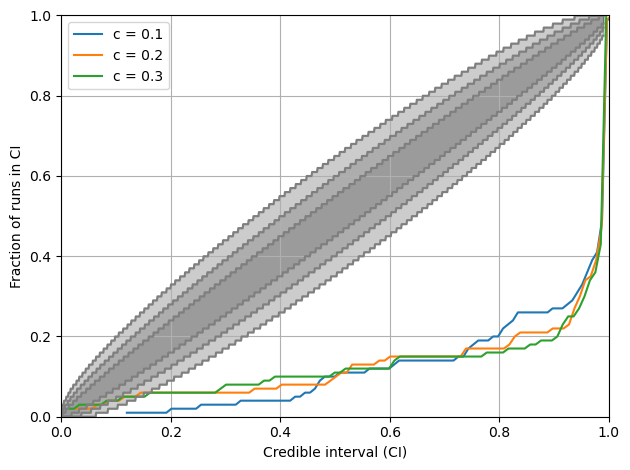

In [66]:
plot_pp(specz_inference_results.get('not_weighted'), f'specz_inference-not_weighted_ngw={n_gw}_nsim={n_sim}')

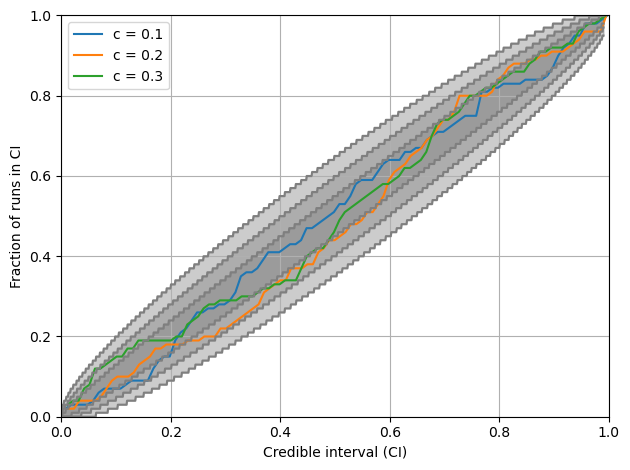

In [67]:
plot_pp(specz_inference_results.get('weighted'), f'specz_inference-weighted_ngw={n_gw}_nsim={n_sim}')

In [68]:
photoz_inference_results = {'weighted':{}, 'not_weighted':{}}
for c in c_values:
    data, counts, bins = pp_analysis_photoz(n_sim, H0_array, c, z, z_gal, n_gw_per_dir, event_weights=mass_gal, desc=f"photoz-not_weighted_c_{c}")
    photoz_inference_results['not_weighted'].update(**{f'c = {c}':(counts, bins)})
    write_to_hdf5(output_data_filename, prefix='photoz/not_weighted/', data={f'c={c}': data})

    data, counts, bins = pp_analysis_photoz(n_sim, H0_array, c, z, z_gal, n_gw_per_dir, event_weights=mass_gal, inference_weights=mass_gal, desc=f"photoz-weighted_c_{c}")
    photoz_inference_results['weighted'].update(**{f'c = {c}':(counts, bins)})
    write_to_hdf5(output_data_filename, prefix='photoz/weighted/', data={f'c={c}': data})

photoz-weighted_c_0.3: 100%|██████████| 100/100 [12:35<00:00,  7.55s/it]


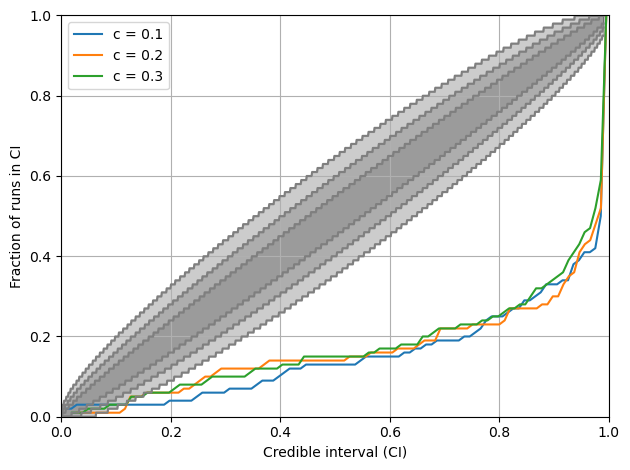

In [69]:
plot_pp(photoz_inference_results.get('not_weighted'), f'photoz_inference-not_weighted_ngw={n_gw}_nsim={n_sim}')

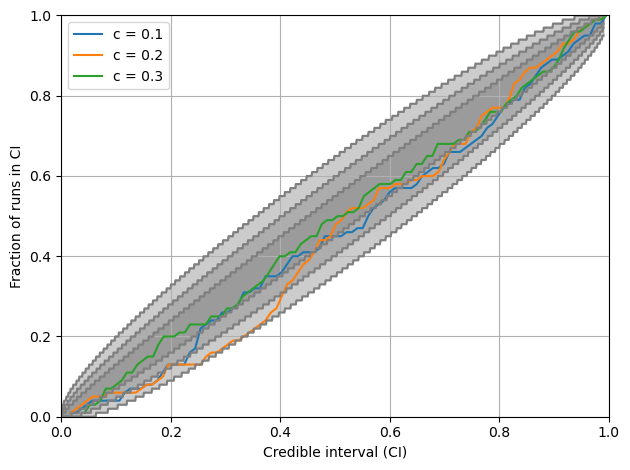

In [70]:
plot_pp(photoz_inference_results.get('weighted'), f'photoz_inference-weighted_ngw={n_gw}_nsim={n_sim}')